In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.autograd as autograd
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import pathlib
from random import shuffle
from tqdm import tqdm

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import backend as K


from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical as to_cat


# CNN MNIST Data Prep


In [ ]:
transformer = transforms.Compose([
    transforms.Resize((28, 28)), #Ensure all sizes are the same
    #transforms.RandomHorizontalFlip(), #Add uniqueness by having some images be flipped
    transforms.ToTensor(), #Change pixel range of color channels, and converts to tensor
    transforms.Normalize((0.5,), (0.5,)) #Change to 1 rgb channel since its grey, mean/standard deviation 0.5
])

In [ ]:
pt_train = torchvision.datasets.MNIST( #Download MNIST dataset
    root='./data', #Where to store data
    train=True, #Whether to set as training data or not
    download=True,
    transform=transformer #Apply transformer
    )

pt_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transformer
    )

100%|██████████| 9912422/9912422 [00:00<00:00, 114301887.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104879388.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28500217.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9670319.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
batch_size = 256 #Establish batch size, and allow for tuning

pt_train_loader = DataLoader(dataset=pt_train, #point to training dataset
                          batch_size=batch_size,
                          shuffle=True #Shuffles to remove bias
                          )

pt_test_loader = DataLoader(dataset=pt_test,
                         batch_size=batch_size,
                         shuffle=False
                         )

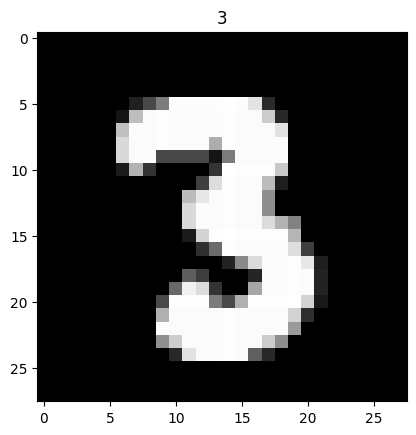

In [ ]:
imgId = torch.randint(len(pt_train), size=(1,)).item() #Generates a random integer index within the range of the number of samples
image, label = pt_train[imgId] #Take random ints image & squeezes it to remove a potential single-dimensional axis


plt.title(label) #Set title to image label
plt.imshow(image.squeeze(), cmap='gray') #Display the image
plt.show()

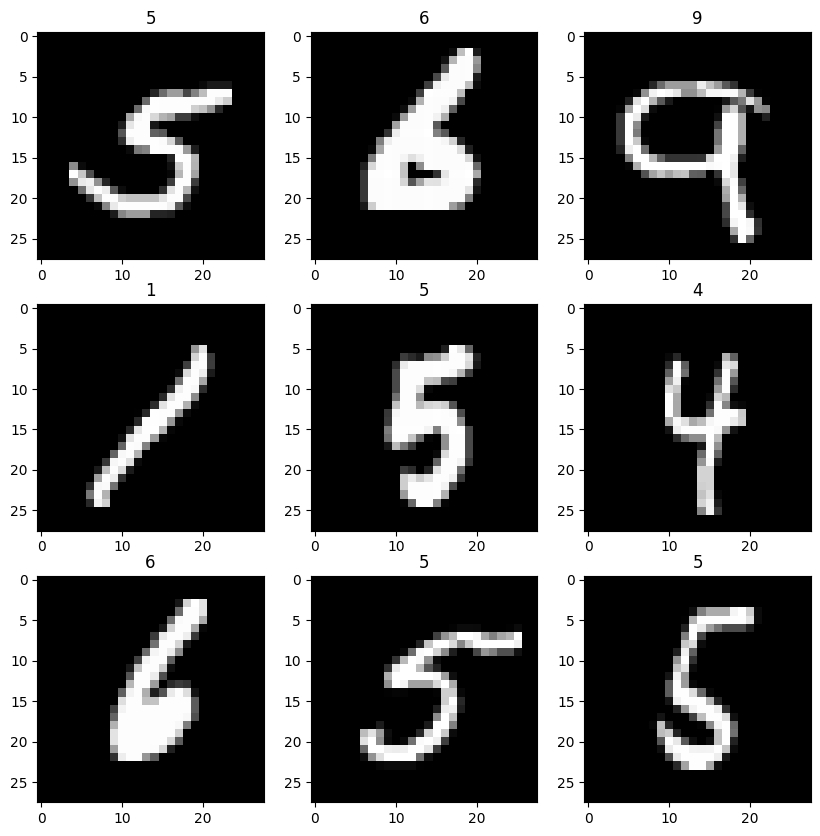

In [ ]:
#Some more visualization
figure = plt.gcf()
figure.set_size_inches(10, 10)
for i in range(1, 10):
  imgId = torch.randint(len(pt_train), size=(1,)).item()
  image, label = pt_train[imgId]
  plt.subplot(3, 3, i)
  axis = plt.gca()
  axis.set_title(str(label))
  plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# CNN MNIST with Pytorch

In [ ]:
in_channels = 1 #Number of RGB channels
dropout_prob = 0.2 #Dropout possibility
kernel_size = 3 #Number of kernels the CNN will scan at a time
learning_rate = 0.01
n_epochs = 20


class MNIST_CNN(nn.Module): #Inherit from Neural Network module--which is the base class for all nn in pytorch
    def __init__(self): #Initialize
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size) #The actual layers of training, that go through each pixel
        self.bn1 = nn.BatchNorm2d(64) #Normalizes layers
        self.pool = nn.MaxPool2d(2, 2) #Pools together convolution layers
        self.fc1 = nn.Linear(16 * 26 * 26, 120) #Based on data size & reshapes layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=dropout_prob) #Prevent overfitting
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x)))) #Applies convolution, normalization, and pooling to the input
        x = x.view(-1, 16 * 26 * 26) #Based on data size
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = MNIST_CNN()
loss_fn = nn.CrossEntropyLoss() #Loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate) #Optimizer

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(n_epochs):
    model.train() #Training Mode

    train_loss_history_epoch = []
    train_acc_history_epoch = []


    for inputs, labels in pt_train_loader:
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Training loss and accuracy
        train_loss_history_epoch.append(loss.item())
        _, predicted = torch.max(y_pred, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        train_acc_history_epoch.append(accuracy)

    train_loss_history.append(np.mean(train_loss_history_epoch))
    train_acc_history.append(np.mean(train_acc_history_epoch))

    model.eval() #Validation mode after each epoch
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs_val, labels_val in pt_test_loader:
            y_pred_val = model(inputs_val)
            loss_val = loss_fn(y_pred_val, labels_val)
            val_loss += loss_val.item()

            _, predicted_val = torch.max(y_pred_val, 1)
            correct_val += (predicted_val == labels_val).sum().item()
            total_val += len(labels_val)

    avg_val_loss = val_loss / len(pt_test_loader)
    val_acc = correct_val / total_val

    #Validation loss and accuracy
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch + 1}/{n_epochs}, "
          f"Training Loss: {np.mean(train_loss_history_epoch):.4f}, "
          f"Training Acc: {np.mean(train_acc_history_epoch) * 100:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Acc: {val_acc * 100:.2f}")




Epoch 1/20, Training Loss: 0.7866, Training Acc: 79.44%, Validation Loss: 0.2999, Validation Acc: 91.91
Epoch 2/20, Training Loss: 0.3023, Training Acc: 91.37%, Validation Loss: 0.2048, Validation Acc: 94.10
Epoch 3/20, Training Loss: 0.2263, Training Acc: 93.55%, Validation Loss: 0.1586, Validation Acc: 95.42
Epoch 4/20, Training Loss: 0.1829, Training Acc: 94.72%, Validation Loss: 0.1333, Validation Acc: 96.15
Epoch 5/20, Training Loss: 0.1553, Training Acc: 95.55%, Validation Loss: 0.1138, Validation Acc: 96.67
Epoch 6/20, Training Loss: 0.1353, Training Acc: 96.11%, Validation Loss: 0.0986, Validation Acc: 97.09
Epoch 7/20, Training Loss: 0.1190, Training Acc: 96.64%, Validation Loss: 0.0906, Validation Acc: 97.31
Epoch 8/20, Training Loss: 0.1085, Training Acc: 96.94%, Validation Loss: 0.0863, Validation Acc: 97.50
Epoch 9/20, Training Loss: 0.0985, Training Acc: 97.17%, Validation Loss: 0.0763, Validation Acc: 97.66
Epoch 10/20, Training Loss: 0.0902, Training Acc: 97.42%, Valida

In [ ]:
#Gather predictions and y_test from data/model in order to be used for comparisions
model.eval()
cnn_preds = []
y_test = []

with torch.no_grad():
    for inputs_test, labels_test in pt_test_loader:
        y_test.extend(labels_test.cpu().numpy())
        y_pred_test = model(inputs_test)
        _, predicted_test = torch.max(y_pred_test, 1)
        cnn_preds.extend(predicted_test.cpu().numpy())

In [ ]:
#Convert to numpy
pt_preds = np.array(cnn_preds)
pt_y_test = np.array(y_test)

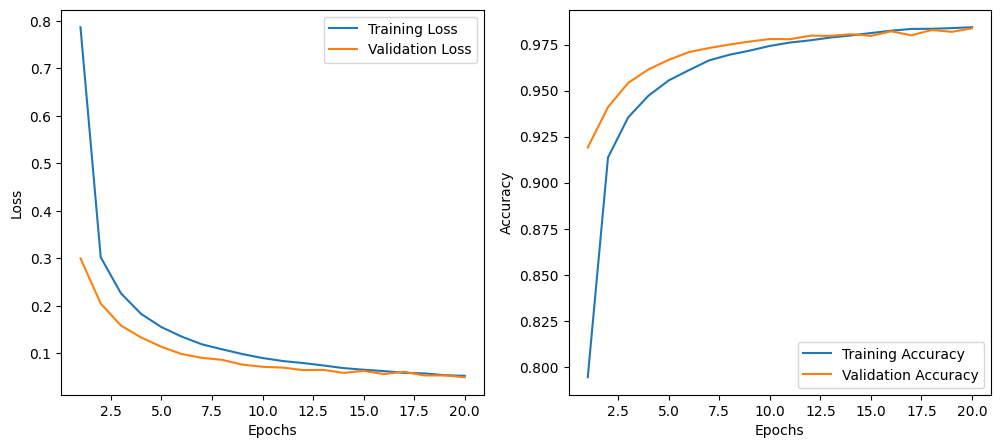

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, n_epochs + 1), train_loss_history, label="Training Loss")
plt.plot(np.arange(1, n_epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, n_epochs + 1), train_acc_history, label="Training Accuracy")
plt.plot(np.arange(1, n_epochs + 1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# CNN CIFAR10 Data Prep

In [ ]:
cifar_transformer = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


cifar_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=cifar_transformer
)

cifar_test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=cifar_transformer
)

100%|██████████| 170498071/170498071 [00:04<00:00, 40778314.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size = 256

cifar_train_loader = DataLoader(
    dataset=cifar_train,
    batch_size=batch_size,
    shuffle=True
)

cifar_test_loader = DataLoader(
    dataset=cifar_test,
    batch_size=batch_size,
    shuffle=False
)

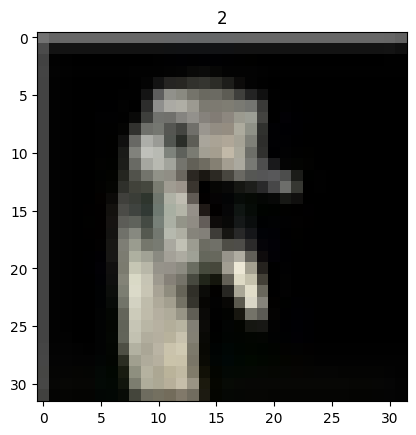

In [ ]:
img_id = torch.randint(len(cifar_train), size=(1,)).item()
cifar_image, cifar_label = cifar_train[img_id]

plt.title(cifar_label)
plt.imshow(np.transpose(cifar_image, (1, 2, 0)))
plt.show()

# CNN CIFAR10 with Pytorch

In [ ]:
cifar_in_channels = 3
cifar_dropout_prob = 0.3
cifar_kernel_size = 3
cifar_learning_rate = 0.001
cifar_n_epochs = 40
weight_decay = 1e-4

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(cifar_in_channels, 64, cifar_kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, cifar_kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=cifar_dropout_prob)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cifar_model = CIFAR10_CNN()
cifar_loss_fn = nn.CrossEntropyLoss()
cifar_optimizer = optim.Adam(cifar_model.parameters(), lr=cifar_learning_rate, weight_decay=weight_decay)
scheduler = StepLR(cifar_optimizer, step_size=10, gamma=0.1)


cifar_train_loss_history = []
cifar_train_acc_history = []
cifar_val_loss_history = []
cifar_val_acc_history = []

for epoch in range(cifar_n_epochs):
    cifar_model.train()

    cifar_train_loss_epoch = []
    cifar_train_acc_epoch = []

    for inputs, labels in cifar_train_loader:
        cifar_y_pred = cifar_model(inputs)
        cifar_loss = cifar_loss_fn(cifar_y_pred, labels)
        cifar_optimizer.zero_grad()
        cifar_loss.backward()
        cifar_optimizer.step()

        cifar_train_loss_epoch.append(cifar_loss.item())
        _, cifar_predicted = torch.max(cifar_y_pred, 1)
        cifar_correct = (cifar_predicted == labels).sum().item()
        cifar_accuracy = cifar_correct / len(labels)
        cifar_train_acc_epoch.append(cifar_accuracy)

    cifar_train_loss_history.append(np.mean(cifar_train_loss_epoch))
    cifar_train_acc_history.append(np.mean(cifar_train_acc_epoch))

    cifar_model.eval()
    cifar_val_loss = 0.0
    cifar_correct_val = 0
    cifar_total_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in cifar_test_loader:
            cifar_y_pred_val = cifar_model(inputs_val)
            cifar_loss_val = cifar_loss_fn(cifar_y_pred_val, labels_val)
            cifar_val_loss += cifar_loss_val.item()

            _, cifar_predicted_val = torch.max(cifar_y_pred_val, 1)
            cifar_correct_val += (cifar_predicted_val == labels_val).sum().item()
            cifar_total_val += len(labels_val)

    avg_cifar_val_loss = cifar_val_loss / len(cifar_test_loader)
    cifar_val_acc = cifar_correct_val / cifar_total_val

    cifar_val_loss_history.append(avg_cifar_val_loss)
    cifar_val_acc_history.append(cifar_val_acc)

    print(f"CIFAR-10 Epoch {epoch + 1}/{cifar_n_epochs}, "
          f"Training Loss: {np.mean(cifar_train_loss_epoch):.4f}, "
          f"Training Acc: {np.mean(cifar_train_acc_epoch) * 100:.2f}%, "
          f"Validation Loss: {avg_cifar_val_loss:.4f}, "
          f"Validation Acc: {cifar_val_acc * 100:.2f}")


CIFAR-10 Epoch 1/40, Training Loss: 1.5663, Training Acc: 42.62%, Validation Loss: 1.3121, Validation Acc: 52.60
CIFAR-10 Epoch 2/40, Training Loss: 1.1835, Training Acc: 57.40%, Validation Loss: 1.0114, Validation Acc: 64.20
CIFAR-10 Epoch 3/40, Training Loss: 1.0545, Training Acc: 62.57%, Validation Loss: 1.0077, Validation Acc: 64.36
CIFAR-10 Epoch 4/40, Training Loss: 0.9702, Training Acc: 65.64%, Validation Loss: 1.0124, Validation Acc: 64.75
CIFAR-10 Epoch 5/40, Training Loss: 0.9113, Training Acc: 67.86%, Validation Loss: 0.9711, Validation Acc: 67.40
CIFAR-10 Epoch 6/40, Training Loss: 0.8629, Training Acc: 69.83%, Validation Loss: 1.0150, Validation Acc: 65.02
CIFAR-10 Epoch 7/40, Training Loss: 0.8216, Training Acc: 71.14%, Validation Loss: 0.8098, Validation Acc: 71.65
CIFAR-10 Epoch 8/40, Training Loss: 0.7779, Training Acc: 72.62%, Validation Loss: 0.8366, Validation Acc: 71.13
CIFAR-10 Epoch 9/40, Training Loss: 0.7479, Training Acc: 73.48%, Validation Loss: 0.9367, Valid

In [ ]:
cifar_model.eval()
cifar_preds = []
cifar_y_test = []

with torch.no_grad():
    for inputs_test, labels_test in cifar_test_loader:
        cifar_y_test.extend(labels_test.cpu().numpy())
        cifar_y_pred_test = cifar_model(inputs_test)
        _, cifar_predicted_test = torch.max(cifar_y_pred_test, 1)
        cifar_preds.extend(cifar_predicted_test.cpu().numpy())


cifar_preds = np.array(cifar_preds)
cifar_y_test = np.array(cifar_y_test)

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, cifar_n_epochs + 1), cifar_train_loss_history, label="Training Loss")
plt.plot(np.arange(1, cifar_n_epochs + 1), cifar_val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, cifar_n_epochs + 1), cifar_train_acc_history, label="Training Accuracy")
plt.plot(np.arange(1, cifar_n_epochs + 1), cifar_val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# TensorFlow MNIST Data Prep

In [ ]:
batch_size = 256

def preprocess_tf(data):
    image = data['image']
    image = tf.image.resize(image, (28, 28))
    image = tf.image.random_flip_left_right(image)
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - 0.5) / 0.5
    label = data['label']
    label = tf.one_hot(label, depth=10)
    return image, label

In [ ]:
tf_train = tfds.load('mnist', split='train', shuffle_files=True)
tf_test = tfds.load('mnist', split='test', shuffle_files=True)

tf_train = tf_train.map(preprocess_tf)
tf_test = tf_test.map(preprocess_tf)

tf_train = tf_train.shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
tf_test = tf_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)



# CNN with TensorFlow

In [ ]:
num_classes = 10
epochs = 20

In [ ]:
TF_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


TF_CNN.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, epsilon=1e-08),
               loss='categorical_crossentropy',
               metrics=['acc'])

In [ ]:
history = TF_CNN.fit(tf_train,
          epochs=epochs,
          validation_data=tf_test)

test_loss, test_accuracy = TF_CNN.evaluate(tf_test)

Epoch 1/20
235/235 [==============================] - 12s 18ms/step - loss: 0.7829 - acc: 0.7567 - val_loss: 0.1291 - val_acc: 0.9590
Epoch 2/20
235/235 [==============================] - 7s 18ms/step - loss: 0.1774 - acc: 0.9464 - val_loss: 0.0937 - val_acc: 0.9725
Epoch 3/20
235/235 [==============================] - 6s 14ms/step - loss: 0.1364 - acc: 0.9599 - val_loss: 0.0845 - val_acc: 0.9764
Epoch 4/20
235/235 [==============================] - 7s 16ms/step - loss: 0.1240 - acc: 0.9634 - val_loss: 0.0758 - val_acc: 0.9746
Epoch 5/20
235/235 [==============================] - 8s 19ms/step - loss: 0.1129 - acc: 0.9667 - val_loss: 0.0602 - val_acc: 0.9836
Epoch 6/20
235/235 [==============================] - 9s 18ms/step - loss: 0.1137 - acc: 0.9672 - val_loss: 0.0783 - val_acc: 0.9769
Epoch 7/20
235/235 [==============================] - 7s 15ms/step - loss: 0.1107 - acc: 0.9682 - val_loss: 0.0560 - val_acc: 0.9839
Epoch 8/20
235/235 [==============================] - 7s 17ms/step -

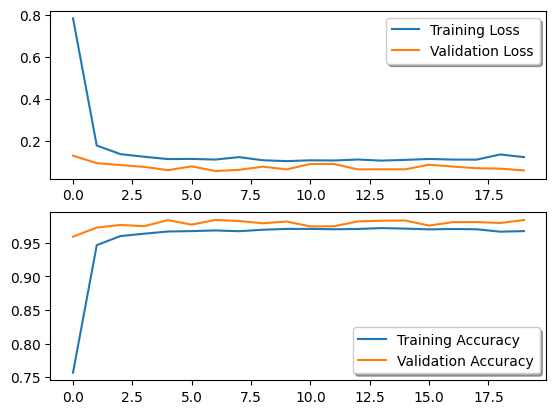

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], label="Training Loss")
ax[0].plot(history.history['val_loss'], label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], label="Training Accuracy")
ax[1].plot(history.history['val_acc'], label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Logistic Regression MNIST Data Prep

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=21)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
def preprocess_sklearn(images, labels):
    images = images.reshape((images.shape[0], -1))
    images = images.astype(np.float32) / 255.0
    images = (images - 0.5) / 0.5
    labels = labels.astype(np.int32)
    return images, labels

def preprocess_forImage(images, labels):
    images = images.reshape((images.shape[0], 28, 28))
    images = tf.cast(images, tf.float32) / 255.0
    images = (images - 0.5) / 0.5
    labels = to_categorical(labels, num_classes=10)
    return images, labels

In [ ]:
lr_x_train, lr_y_train = preprocess_forImage(x_train, y_train)
lr_x_test, lr_y_test = preprocess_forImage(x_test, y_test)

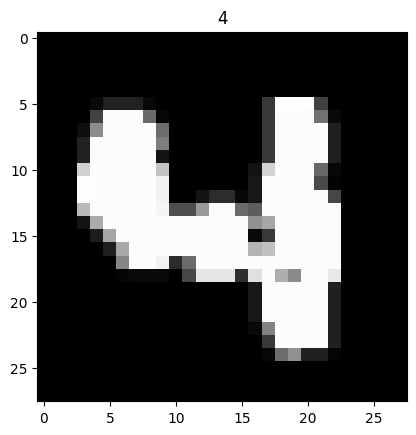

In [ ]:
imgId = torch.randint(len(lr_x_train), size=(1,)).item()
image = lr_x_train[imgId]
label = lr_y_train[imgId]

plt.title(label.argmax())
plt.imshow(image, cmap='gray')
plt.show()


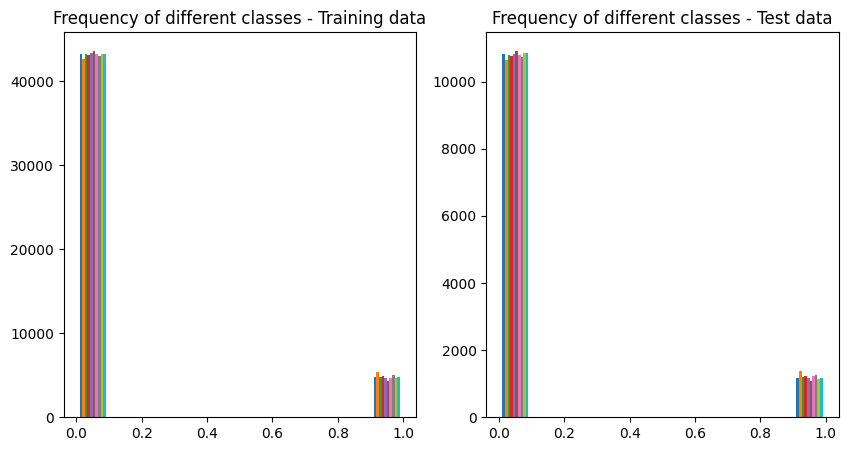

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(lr_y_train);
plt.title('Frequency of different classes - Training data');

plt.subplot(1,2,2)
plt.hist(lr_y_test);
plt.title('Frequency of different classes - Test data');

In [ ]:
lr_x_train, lr_y_train = preprocess_sklearn(x_train, y_train)
lr_x_test, lr_y_test = preprocess_sklearn(x_test, y_test)

# Logistic Regression


In [ ]:
# param_grid = {
#     'C': [1, 10, 50],
#     'tol': [0.0001, 0.001, 0.01],
# }

# grid_search = GridSearchCV(
    # LogisticRegression(fit_intercept=True, multi_class='auto', solver='saga', max_iter=1000, verbose=2, n_jobs=5),
#     param_grid,
#     cv=5,
#     verbose=2
# )

lr_model = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l1',
                        solver='saga',
                        max_iter=1000,
                        C=50,
                        verbose=2,
                        n_jobs=5,
                        tol=0.01
                         )

In [ ]:
# grid_search.fit(lr_x_train, lr_y_train)

# print("Best Parameters: ", grid_search.best_params_)

# best_lr_model = grid_search.best_estimator_

lr_model.fit(lr_x_train, lr_y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 45 epochs took 295 seconds


LogisticRegression(C=50, max_iter=1000, n_jobs=5, penalty='l1', solver='saga',
                   tol=0.01, verbose=2)

In [ ]:
lr_train_loss = log_loss(lr_y_train, lr_model.predict_proba(lr_x_train))
lr_train_accuracy = lr_model.score(lr_x_train, lr_y_train)

lr_test_loss = log_loss(lr_y_test, lr_model.predict_proba(lr_x_test))
lr_test_accuracy = lr_model.score(lr_x_test, lr_y_test)

print(f"Training Loss: {lr_train_loss:.4f}, Training Acc: {lr_train_accuracy * 100:.2f}%")
print(f"Test Loss: {lr_test_loss:.4f}, Test Acc: {lr_test_accuracy * 100:.2f}%")

Training Loss: 0.2181, Training Acc: 93.97%
Test Loss: 0.2890, Test Acc: 92.19%


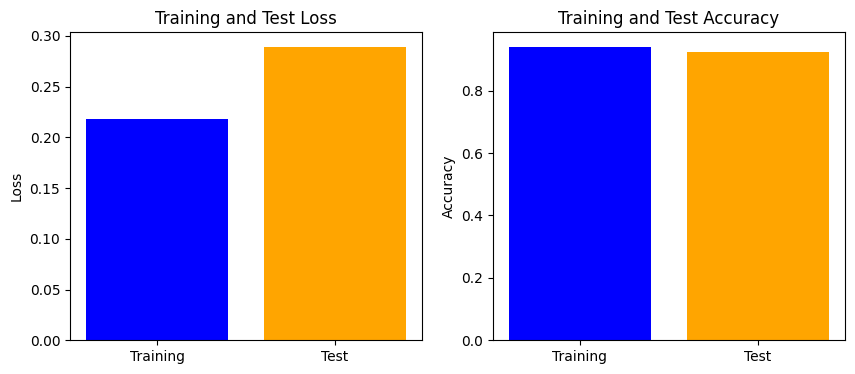

In [ ]:
labels = ['Training', 'Test']
loss_values = [lr_train_loss, lr_test_loss]
accuracy_values = [lr_train_accuracy, lr_test_accuracy]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Training and Test Loss')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.title('Training and Test Accuracy')
plt.ylabel('Accuracy')

plt.show()

# SVM MNIST Data Prep

In [ ]:
#Just use the same data as the LR model.
svm_x_train, svm_y_train = lr_x_train, lr_y_train
svm_x_test, svm_y_test = lr_x_test, lr_y_test

# SVM


In [ ]:
svm_model = SVC(kernel='linear', C=1.0, probability=True)
svm_model.fit(svm_x_train, svm_y_train)

SVC(kernel='linear', probability=True)

In [ ]:
svm_train_loss = log_loss(svm_y_train, svm_model.predict_proba(svm_x_train))
svm_train_accuracy = svm_model.score(svm_x_train, svm_y_train)

svm_test_loss = log_loss(svm_y_test, svm_model.predict_proba(svm_x_test))
svm_test_accuracy = svm_model.score(svm_x_test, svm_y_test)

print(f"Training Loss: {svm_train_loss:.4f}, Training Acc: {svm_train_accuracy * 100:.2f}%")
print(f"Test Loss: {svm_test_loss:.4f}, Test Acc: {svm_test_accuracy * 100:.2f}%")

Training Loss: 0.1411, Training Acc: 98.10%
Test Loss: 0.2499, Test Acc: 92.72%


# Comparision


In [ ]:
tf_preds = TF_CNN.predict(tf_test)
tf_test_labels = np.concatenate([label.numpy() for _, label in tf_test], axis=0)
tf_y_test = np.argmax(tf_test_labels, axis=1)
tf_preds_int = np.argmax(tf_preds, axis=1)
tf_accuracy = accuracy_score(tf_y_test, tf_preds_int)



lr_preds = lr_model.predict(lr_x_test)
svm_preds = svm_model.predict(svm_x_test)


pt_accuracy = accuracy_score(pt_y_test, pt_preds)
lr_accuracy = accuracy_score(lr_y_test, lr_preds)
svm_accuracy = accuracy_score(svm_y_test, svm_preds)

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



40/40 [==============================] - 1s 15ms/step


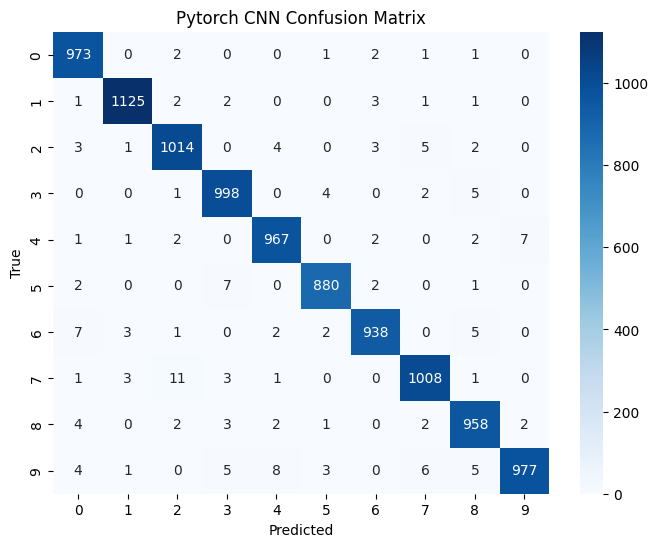

Pytorch CNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
plot_confusion_matrix(pt_y_test, pt_preds, title='Pytorch CNN Confusion Matrix')
print("Pytorch CNN Classification Report:")
print(classification_report(pt_y_test, pt_preds))

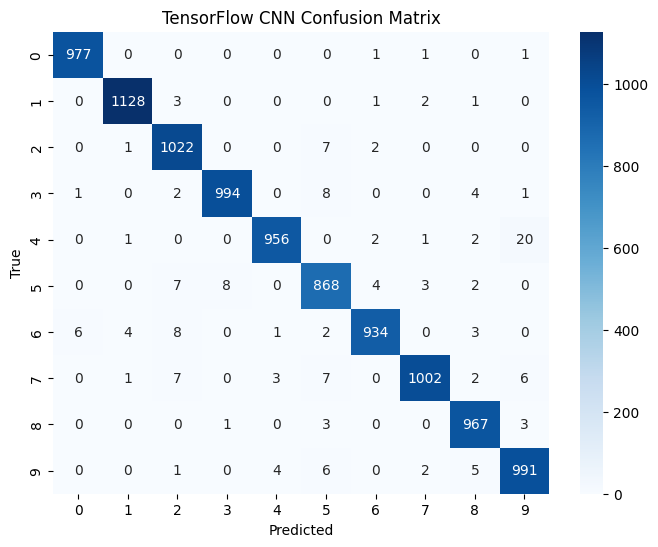

TensorFlow CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.96      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
plot_confusion_matrix(tf_y_test, tf_preds_int, title='TensorFlow CNN Confusion Matrix')
print("TensorFlow CNN Classification Report:")
print(classification_report(tf_y_test, tf_preds_int))

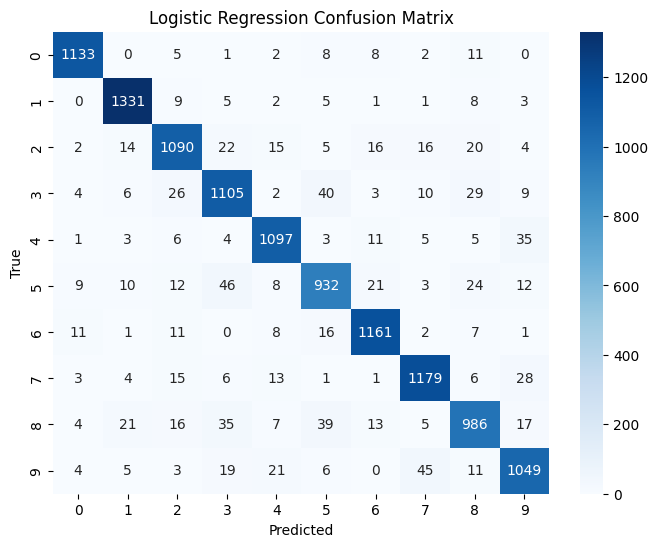

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1170
           1       0.95      0.98      0.96      1365
           2       0.91      0.91      0.91      1204
           3       0.89      0.90      0.89      1234
           4       0.93      0.94      0.94      1170
           5       0.88      0.87      0.87      1077
           6       0.94      0.95      0.95      1218
           7       0.93      0.94      0.93      1256
           8       0.89      0.86      0.88      1143
           9       0.91      0.90      0.90      1163

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



In [ ]:
plot_confusion_matrix(lr_y_test, lr_preds, title='Logistic Regression Confusion Matrix')

print("Logistic Regression Classification Report:")
print(classification_report(lr_y_test, lr_preds))


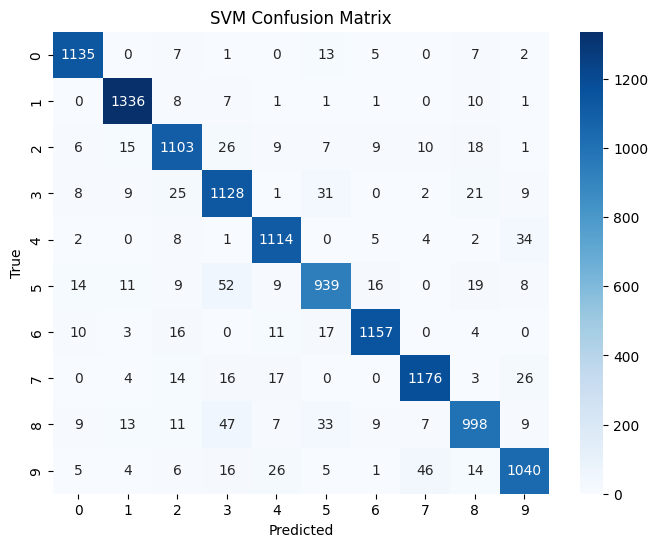

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1170
           1       0.96      0.98      0.97      1365
           2       0.91      0.92      0.91      1204
           3       0.87      0.91      0.89      1234
           4       0.93      0.95      0.94      1170
           5       0.90      0.87      0.88      1077
           6       0.96      0.95      0.96      1218
           7       0.94      0.94      0.94      1256
           8       0.91      0.87      0.89      1143
           9       0.92      0.89      0.91      1163

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



In [ ]:
plot_confusion_matrix(svm_y_test, svm_preds, title='SVM Confusion Matrix')

print("SVM Classification Report:")
print(classification_report(svm_y_test, svm_preds))

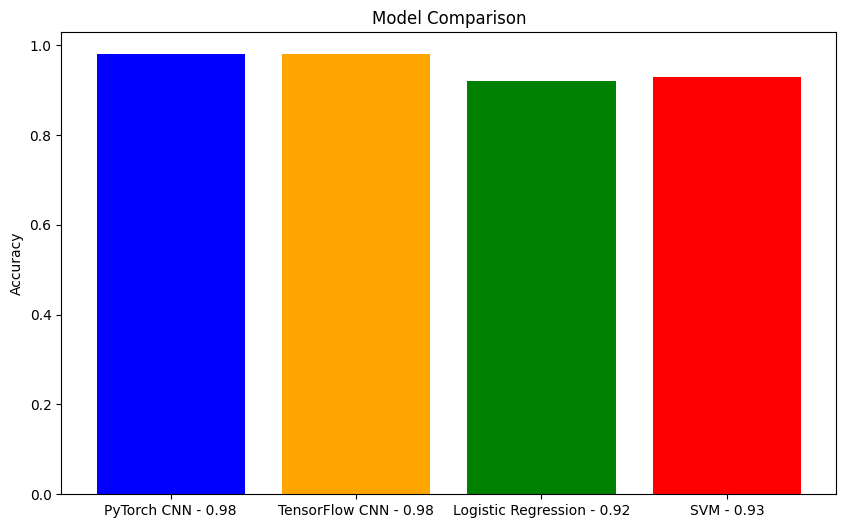

In [ ]:
accuracies = [pt_accuracy, tf_accuracy, lr_accuracy, svm_accuracy]

formatted_accuracies = [round(acc, 2) for acc in accuracies]

models = [
    f'PyTorch CNN - {formatted_accuracies[0]}',
    f'TensorFlow CNN - {formatted_accuracies[1]}',
    f'Logistic Regression - {formatted_accuracies[2]}',
    f'SVM - {formatted_accuracies[3]}'
]

plt.figure(figsize=(10, 6))
plt.bar(models, formatted_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()